## To-do
- Transforming some numerical variables that seem really categorical
- Label Encoding categorical variables that may contain information in their ordering set


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import util_michael as util_m
from util import *

In [2]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    display(x)
    pd.reset_option('display.max_rows')

In [3]:
train = pd.read_csv('./data/cl_train.csv', na_filter=False) 
test = pd.read_csv('./data/cl_test.csv', na_filter=False)
# na_filter set to False because some cells have the 'NA' value which is a valid input
brk = train.shape[0]
train.shape, test.shape

((1460, 78), (1459, 77))

In [4]:
comb = pd.concat([train, test], ignore_index=True, sort=False)
comb.shape

(2919, 78)

* Check that all features are complete

In [5]:
summary_missing_data(comb)

,Count,Percent
SalePrice,1459,0.499829


# Feature Engineering

## 1 Labeling

### 1a) Turn categorical features that could be interpreted as ordinal features (ratings as Poor, Good, Excellent, etc.)

In [6]:
rating_map_type1 = { 'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5 }
fts_type1 = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 
       'FireplaceQu', 'GarageQual', 'GarageCond']
for f in fts_type1:
    comb[f] = comb[f].map(rating_map_type1)
    comb[f] = comb[f].astype('int8')

    
rating_map_type2 = { 'NA': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4 }
fts_type2 = ['BsmtExposure']
for f in fts_type2:
    comb[f] = comb[f].map(rating_map_type2)
    comb[f] = comb[f].astype('int8')

    
rating_map_type3 = { 'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6 }
fts_type3 = ['BsmtFinType1', 'BsmtFinType2']
for f in fts_type3:
    comb[f] = comb[f].map(rating_map_type3)
    comb[f] = comb[f].astype('int8')


rating_map_type4 = { 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3 }
fts_type4 = ['GarageFinish']
for f in fts_type4:
    comb[f] = comb[f].map(rating_map_type4)
    comb[f] = comb[f].astype('int8')
    

# rating_map_type5 = { 'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4 }
# fts_type5 = ['Fence']
# for f in fts_type5:
#     comb[f] = comb[f].map(rating_map_type5)

In [7]:
print('Features labeled:', len( fts_type1 + fts_type2 + fts_type3 + fts_type4 ))

Features labeled: 13


### 1b) Turn categorical features with OneHotEncode

In [8]:
cols_to_dummy = [
    'MSSubClass', 'MSZoning', 'BldgType', 'HouseStyle', 'Street', 'LotShape',
    'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
    'Condition2', 'YearBuilt', 'YearRemodAdd', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
    'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'Functional',
    'GarageType', 'PavedDrive', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition'
]
dumbcomb = pd.get_dummies(comb, columns=cols_to_dummy)

In [9]:
print('Features dummified:', len(cols_to_dummy))

Features dummified: 31


In [10]:
dumbcomb.shape

(2919, 438)

## 3 Playground ~ Create new features

In [11]:
def create_new_ft(df: pd.DataFrame, new_ft: str, fts_to_combine: list or dict) -> pd.DataFrame:
    """
        Creates a new feature
        :param new_ft: the name of the resulting new feature
        :param fts_to_combine: 
            if given a list, all features to combine are weighted equally
            if given a dict, each feature in the dict will have a given weight
    """
    dfc = df.copy()
    if new_ft not in list(dfc.columns):
        dfc[new_ft] = 0
        if type(fts_to_combine) == list:
            for f in fts_to_combine:
                dfc[new_ft] += dfc[f]
        elif type(fts_to_combine) == dict:
            for f, weight in fts_to_combine.items():
                dfc[new_ft] += weight * dfc[f]
    else:
        print("Exception: New feature not created as it already exists in given DataFrame")
    return dfc

* Sum all house qualities

In [12]:
new_ft = '_TotalQuality'
ft_quality = ['OverallQual', 'ExterQual', 'BsmtQual', 'HeatingQC', 'KitchenQual', 
              'FireplaceQu', 'GarageQual']
dumbcomb = create_new_ft(dumbcomb, new_ft, ft_quality)

* Sum all house conditions

In [13]:
new_ft = '_TotalConditions'
ft_quality = ['OverallCond', 'ExterCond', 'BsmtCond', 'HeatingQC', 'GarageCond']
dumbcomb = create_new_ft(dumbcomb, new_ft, ft_quality)

* Check square feets for each section of the houses and try to create a **_TotalSF** feature without overlapping

In [14]:
# See these areas are dependent
dumbcomb['BsmtFinSF1']+dumbcomb['BsmtFinSF2']+dumbcomb['BsmtUnfSF'] == dumbcomb['TotalBsmtSF']

0       True
1       True
2       True
3       True
4       True
5       True
6       True
7       True
8       True
9       True
10      True
11      True
12      True
13      True
14      True
15      True
16      True
17      True
18      True
19      True
20      True
21      True
22      True
23      True
24      True
25      True
26      True
27      True
28      True
29      True
        ... 
2889    True
2890    True
2891    True
2892    True
2893    True
2894    True
2895    True
2896    True
2897    True
2898    True
2899    True
2900    True
2901    True
2902    True
2903    True
2904    True
2905    True
2906    True
2907    True
2908    True
2909    True
2910    True
2911    True
2912    True
2913    True
2914    True
2915    True
2916    True
2917    True
2918    True
Length: 2919, dtype: bool

In [15]:
# See these areas are dependent
dumbcomb['GrLivArea'] == dumbcomb['1stFlrSF'] + dumbcomb['2ndFlrSF']

0       True
1       True
2       True
3       True
4       True
5       True
6       True
7       True
8       True
9       True
10      True
11      True
12      True
13      True
14      True
15      True
16      True
17      True
18      True
19      True
20      True
21      True
22      True
23      True
24      True
25      True
26      True
27      True
28      True
29      True
        ... 
2889    True
2890    True
2891    True
2892    True
2893    True
2894    True
2895    True
2896    True
2897    True
2898    True
2899    True
2900    True
2901    True
2902    True
2903    True
2904    True
2905    True
2906    True
2907    True
2908    True
2909    True
2910    True
2911    True
2912    True
2913    True
2914    True
2915    True
2916    True
2917    True
2918    True
Length: 2919, dtype: bool

In [16]:
# See these areas are independent
dumbcomb[['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']].sample(10)

,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch
1333,0,65,190,0,0
1671,0,116,0,0,0
990,0,70,0,0,0
1897,329,96,0,0,0
1449,0,0,0,0,0
385,146,20,0,0,144
2467,0,25,77,0,0
346,0,0,0,0,0
2189,0,0,0,0,0
1213,88,0,0,0,0


In [17]:
new_ft = '_TotalSF'
ft_quality = [
              'TotalBsmtSF', 'GrLivArea', 'GarageArea',
              'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
              'PoolArea'
             ]
dumbcomb = create_new_ft(dumbcomb, new_ft, ft_quality)

* Total rooms

In [18]:
dumbcomb[['BedroomAbvGr', 'TotRmsAbvGrd']].sample(10)

,BedroomAbvGr,TotRmsAbvGrd
658,3,6
1797,3,6
1971,3,9
1928,2,4
950,3,5
439,3,7
2838,3,6
731,3,6
1366,3,7
1520,3,6


In [19]:
# new_ft = '_TotalRooms'
# ft_quality = ['']
# dumbcomb = create_new_ft(dumbcomb, new_ft, ft_quality)

* Total bathrooms

In [20]:
new_ft = '_TotalBathrooms'
ft_quality = { 'BsmtFullBath': 1, 'BsmtHalfBath': 0.5, 'FullBath': 1, 'HalfBath': 0.5 }
dumbcomb = create_new_ft(dumbcomb, new_ft, ft_quality)

In [21]:
dumbcomb[['_TotalBathrooms', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']].sample(10)

,_TotalBathrooms,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath
486,2.5,1.0,0.0,1,1
1729,2.0,0.0,0.0,2,0
2644,1.5,0.0,0.0,1,1
625,1.5,0.0,0.0,1,1
2319,2.0,0.0,0.0,2,0
2870,1.0,0.0,0.0,1,0
2051,2.0,1.0,0.0,1,0
2240,2.0,1.0,0.0,1,0
1981,3.0,1.0,0.0,2,0
2389,2.0,1.0,0.0,1,0


* Ratio of the **GrLivArea** relative to the **LotArea**

In [22]:
dumbcomb[['LotArea', 'GrLivArea']].sample(10)

,LotArea,GrLivArea
361,9144,1505
1867,11422,1838
177,13650,1920
27,11478,1704
2358,8012,1266
351,5271,1453
2376,17778,2497
1680,6472,1456
1699,9085,2061
1313,14774,2599


In [23]:
dumbcomb['_Rel_LivAreaOverLotArea'] = dumbcomb['GrLivArea'] / dumbcomb['LotArea']

In [24]:
dumbcomb['_Rel_TQualityOverTSF'] = dumbcomb['_TotalQuality'] / dumbcomb['_TotalSF']
dumbcomb['_Rel_TConditionsOverTSF'] = dumbcomb['_TotalConditions'] / dumbcomb['_TotalSF']

In [25]:
datatrain = dumbcomb.iloc[0:brk,:]
datatest = dumbcomb.iloc[brk:,:].drop(columns=['SalePrice'])
datatrain.shape, datatest.shape

((1460, 445), (1459, 444))

In [26]:
util_m.print_moderate_correlations(datatrain, 'SalePrice', 0.4)

OverallQual :  0.7909816005838047
MasVnrArea :  0.47261449900457725
ExterQual :  0.6826392416562591
BsmtQual :  0.5852071991725148
TotalBsmtSF :  0.6135805515591944
HeatingQC :  0.4276487073988049
1stFlrSF :  0.6058521846919166
GrLivArea :  0.7086244776126511
FullBath :  0.5606637627484452
KitchenQual :  0.6595997207286572
TotRmsAbvGrd :  0.5337231555820238
Fireplaces :  0.4669288367515242
FireplaceQu :  0.5204376059504007
GarageYrBlt :  0.5080432871615157
GarageFinish :  0.5492467563332154
GarageCars :  0.640409197258349
GarageArea :  0.6234314389183598
Neighborhood_NridgHt :  0.40214859817526666
Foundation_PConc :  0.4977337525869438
_TotalQuality :  0.8029271404977033
_TotalSF :  0.8077042407242587
_TotalBathrooms :  0.6317310679319897
_Rel_TQualityOverTSF :  -0.4222617615377976
_Rel_TConditionsOverTSF :  -0.6338765604311236


In [27]:
util_m.print_weak_correlations(datatrain, 'SalePrice', 0.4)

Id :  -0.021916719443431112
LotFrontage :  0.3424734120780685
LotArea :  0.2638433538714063
OverallCond :  -0.0778558940486776
ExterCond :  0.018899118482413147
BsmtCond :  0.2126071564855757
BsmtExposure :  0.3750449589200733
BsmtFinType1 :  0.3049078730706334
BsmtFinSF1 :  0.38641980624215627
BsmtFinType2 :  -0.00432931629117379
BsmtFinSF2 :  -0.011378121450215216
BsmtUnfSF :  0.214479105546969
2ndFlrSF :  0.31933380283206614
LowQualFinSF :  -0.02560613000068015
BsmtFullBath :  0.22712223313149718
BsmtHalfBath :  -0.016844154297359294
HalfBath :  0.2841076755947784
BedroomAbvGr :  0.1682131543007415
KitchenAbvGr :  -0.1359073708421417
GarageQual :  0.27383907400622587
GarageCond :  0.26319078447040084
WoodDeckSF :  0.32441344456813076
OpenPorchSF :  0.31585622711605577
EnclosedPorch :  -0.12857795792595636
3SsnPorch :  0.04458366533574792
ScreenPorch :  0.11144657114291048
PoolArea :  0.09240354949187278
MiscVal :  -0.02118957964030379
MSSubClass_20 :  0.04127392338024072
MSSubClass_

In [28]:
def my_remove_weak_correlations(df1: pd.DataFrame, df2, col_to_correlate: str, y, skip: list=[], weak_threshold: float = 0.1) -> (pd.DataFrame, pd.DataFrame):
    """
    Removes weak correlations
    :param df: pandas DataFrame to remove columns from.
    :param col_to_correlate: String column name to check correlation with
    :param weak_threshold: float number that counts as an absolute weak threshold
    :return: pandas DataFrame without the columns weakly correlated to target
    """
#     col_to_correlate = 'PREDICTOR_TO_CHECK_WEAK_CORRS'
    df1[col_to_correlate] = y
    cols = df1[df1.columns].corr().columns
    corrs = df1[df1.columns].corr()[col_to_correlate]
    strongly_correlated = list()
    for col, corr in zip(cols, corrs):
        if abs(corr) >= weak_threshold and col != col_to_correlate:
            strongly_correlated.append(col)
    df1 = df1.drop(columns=[col_to_correlate])
    for col in df1.columns:
        if col not in strongly_correlated and col not in skip:
            df1.drop(columns=[col], inplace=True)
            df2.drop(columns=[col], inplace=True)
    return df1, df2

In [29]:
Y = datatrain['SalePrice']
datatrain.drop(columns=['SalePrice'], inplace=True)
datatrain, datatest = my_remove_weak_correlations(datatrain, datatest, 'SalePrice', Y, ['Id'])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [30]:
datatrain = pd.concat([datatrain, Y], axis=1)

In [31]:
datatrain.shape, datatest.shape

((1460, 127), (1459, 126))

## 4 Outliers in the training set?

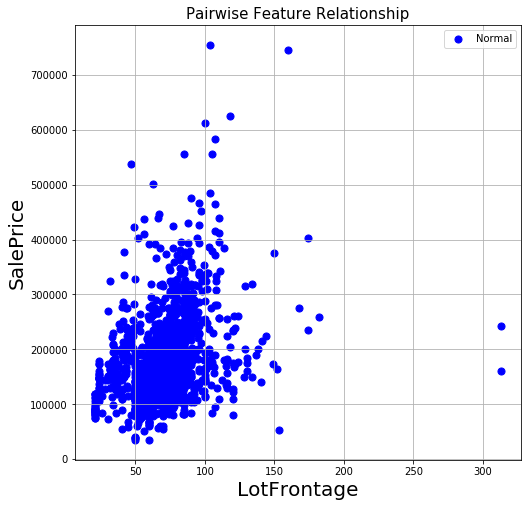

In [32]:
util_m.plot_relationship(datatrain, 'LotFrontage', 'SalePrice')

In [33]:
datatrain.drop( datatrain[ datatrain['LotFrontage'] > 250 ].index, inplace=True )

***

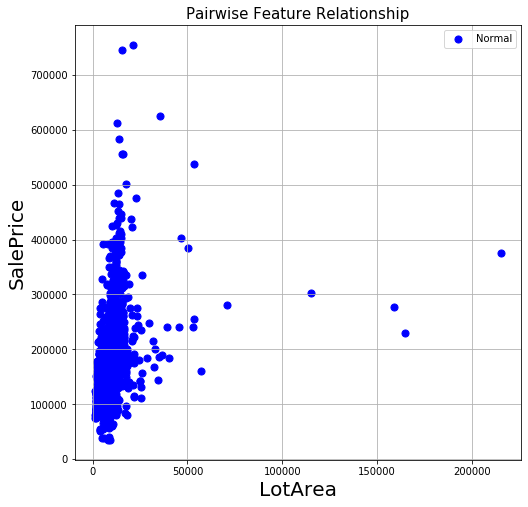

In [34]:
util_m.plot_relationship(datatrain, 'LotArea', 'SalePrice')

In [35]:
datatrain.drop( datatrain[ datatrain['LotArea'] > 50000 ].index, inplace=True )

***

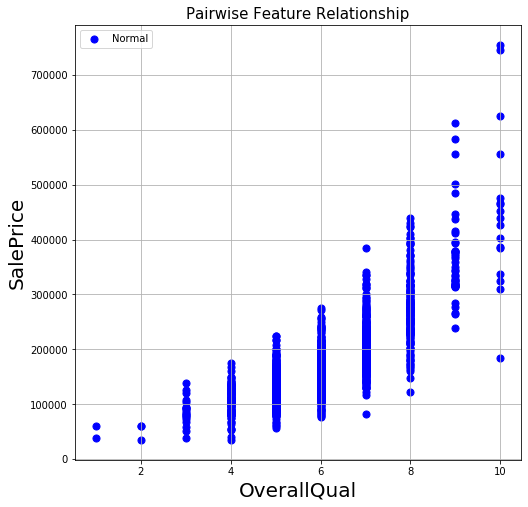

In [36]:
util_m.plot_relationship(datatrain, 'OverallQual', 'SalePrice')

In [37]:
# util_m.plot_relationship(datatrain, 'OverallCond', 'SalePrice')

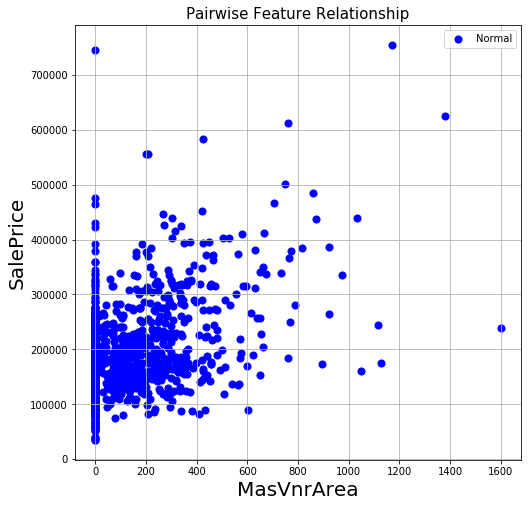

In [38]:
util_m.plot_relationship(datatrain, 'MasVnrArea', 'SalePrice')

## 5 Box cox transform numerical features to adjust skewness

- Don't adjust skewness on the Ids and SalePrice!!

In [39]:
Y = datatrain['SalePrice']
trainid = datatrain['Id']
testid = datatest['Id']

datatrain.drop(columns=['SalePrice', 'Id'], inplace=True)
datatest.drop(columns=['Id'], inplace=True)

In [40]:
datatrain.shape, datatest.shape

((1448, 125), (1459, 125))

In [41]:
util_m.adjust_skewness(datatrain)
util_m.adjust_skewness(datatest);

In [43]:
datatrain = pd.concat([trainid, datatrain, Y], axis=1)
datatest = pd.concat([testid, datatest], axis=1)

# Save file for modeling

In [44]:
datatrain.to_csv('./data/cleaner_train.csv', index=False)
datatest.to_csv('./data/cleaner_test.csv', index=False)